In [2]:
"""
The Boston Housing Price Dataset is an example of regression.
It means that a continous value is predicted. 
It is basically the opposite of classification, where a discrete label is predicted. 

Here I will try to predict the median price of a home, given different data points like crime rate, tax rate etc. 
The difficulty here is that there are not too many values (506) and they do not have the same proportions.
"""


'\nThe Boston Housing Price Dataset is an example of regression.\nIt means that a continous value is predicted. \nIt is basically the opposite of classification, where a discrete label is predicted. \n\nHere I will try to predict the median price of a home, given different data points like crime rate, tax rate etc. \nThe difficulty here is that there are not too many values (506) and they do not have the same proportions.\n'

In [3]:
#Here I import the dataset

from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


65536/57026 [==================================] - 0s 0us/step


In [7]:
#Here I look at the shape of the test data and the train data

print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [9]:
#it shows that there are 404 train samples and 102 test samples, each with 13 features

Now we need to prepare the Data. Unfortunately it will be a bit difficult as the ranges differ widely. 

Thus we need to normalize feature-wise. This happens by substracting the mean from the feature and divide by the standard deviation, so it centeres around 0.

In [13]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /=std

#it must be noted that the features are computed from the training data

Building the Model.

There are very few samples, so a small model will be used with each 64 units. We use a small model to mitigate overfitting, as small models tend to overfit easier. 

In [21]:
def build_model():
  model = keras.Sequential([
                            layers.Dense(64, activation='relu'),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])

  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

Here the model end with a single unit and no activation as this is typical when you are trying to predict a single continous value. With a activatoin function it would actually only be able to output 0 or 1, but due to the linearity it can output any value.

Also, mse (mean squared error) is used here, as it is a widely used loss function for regression problems. "MAE" mean absolute error is the absolute value of the difference between predictions and the target. 

Validating the Model


As we have only few data points here, it is not wise to split the data into a training and validation set. The validation scores might have a high variance with regard to the validation split.

Thus, we will use K-fold cross-validation. We split the dataset in K portions, instantiating k identical models, and train each of them on K-1 partitions, while the evaluation is happening on the remaining ones. 

For the validation score we just take the average of the K-scores. 

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print('processing fold #%d' % i)
  val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
  partial_train_data = np.concatenate (
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
       axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i+1)*num_val_samples:]],
       axis=0)
  
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


In [23]:
all_scores

[2.242794990539551, 2.8922979831695557, 2.8029441833496094, 2.4400596618652344]

In [24]:
np.mean(all_scores)

2.5945242047309875

Here we can see that different runs shows different scores. The average value is around 2.6, this means that the prices are off by around 2600 dollars on average. One might argue that to be a significant difference as the prices only range from around 10,000 dollars to 50,000 dollars.

In [25]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print('processing fold #%d' % i)
  val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
  partial_train_data = np.concatenate (
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
       axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i+1)*num_val_samples:]],
       axis=0)
  
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, 
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs, batch_size=1, verbose=0)
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


In [27]:
average_mae_history = [
                       np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

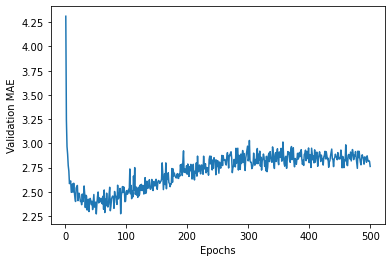

In [29]:
import matplotlib.pyplot as plt


plt.plot(range(1, len(average_mae_history) +1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [30]:
#here the plot is difficult to see, as the first 10 data points are on a different scale.

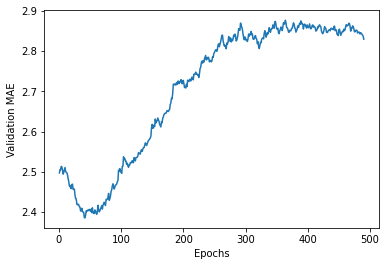

In [36]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [38]:
#here we can see that the model is not erally improving after a certain time anymore. This happens after around 80 epochs.

In [39]:
#now a final model will be trained on all of the training data with the best parameters

In [44]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 19.5172 - mae: 2.7450


In [45]:
test_mae_score

2.74501895904541

As you can see the final result is still off, even more than the previous one. Here, by around 2750$ 

In [46]:
predictions = model.predict(test_data)

In [47]:
predictions[0]

array([9.74002], dtype=float32)

In [48]:
#the first price should be around 10K